<a href="https://colab.research.google.com/github/ProjectsMC/Deteccion_plagas_maiz/blob/main/Generalizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO DE INTELIGENCIA ARTIFICIAL**

MASTER EN AUTOMÁTICA Y ROBÓTICA DE LA UNIVERSIDAD POLITÉCNICA DE MADRID
GRUPO 7


*   Micaela Cabrera 23023
*   Ivonne Quizhe 23146

GENERALIZACIÓN DE RESULTADOS PARA OTRO DATASET





#Cargando librerias

In [1]:
#Se importan las librerías necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
!pip install opendatasets
import opendatasets as od
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
!git clone https://github.com/ProjectsMC/Deteccion_plagas_maiz
%cd /content/Deteccion_plagas_maiz/

Cloning into 'Deteccion_plagas_maiz'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 1.95 MiB | 8.16 MiB/s, done.
/content/Deteccion_plagas_maiz


In [3]:
# @markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


#Se carga el dataset del drive

In [8]:
#Se define el tamaño de las imágenes
IMAGE_SIZE = (256,256)
BATCH_SIZE = 25

In [9]:
#Se carga el dataset definido
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/IA/Propuesta de proyecto/Generalizacion",
    #validation_split=0.2,  # Porcentaje de datos a usar para validación
    #subset="training",
    #seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 75 files belonging to 4 classes.


In [10]:
#Se generan las clases en las que se divide el dataset
class_names = dataset.class_names
class_names

['Blight', 'Common Rust', 'Gray_Leaf_Spot', 'Healthy']

In [11]:
class_names = dataset.class_names
label_counts = {label: 0 for label in class_names}

for images, labels in dataset:
    for label in labels:
        label_name = class_names[label]
        label_counts[label_name] += 1

for label, count in label_counts.items():
    print(f"{label}: {count}")

Blight: 25
Common Rust: 20
Gray_Leaf_Spot: 10
Healthy: 20


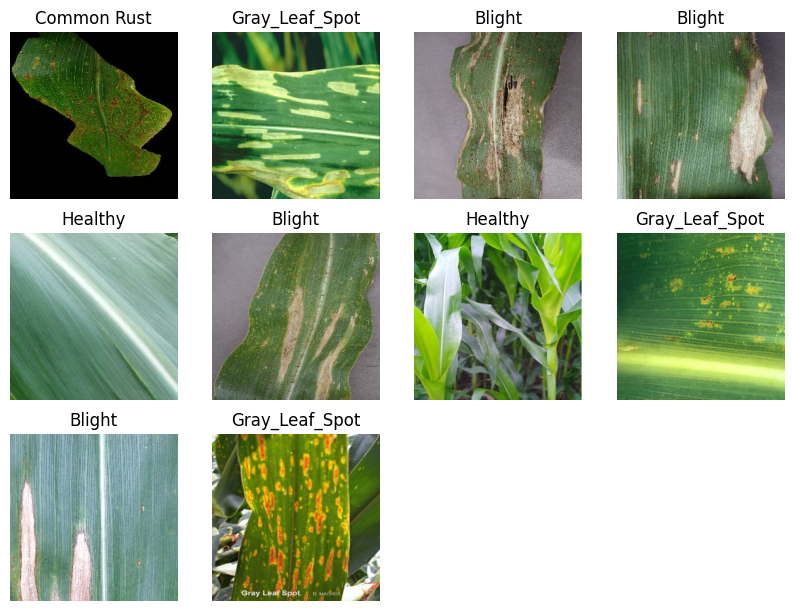

In [16]:
#Se muestran 5 imágenes para corroborar que el dataset esta ok
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [17]:
#Se toma un porcentaje del dataset para crear los datos a validar (serán todos los del dataset)
def get_dataset(ds,test_split=1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)
        test_ds = ds.take(ds_size)

    return test_ds

In [18]:
test_ds = get_dataset(dataset)

In [19]:
#Se corrobora el tamaño
print("\nLength of Testing Dataset is",len(test_ds))


Length of Testing Dataset is 3


In [20]:
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
#Se redimensiona la imagen
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
from keras.models import load_model
model = load_model('/content/Deteccion_plagas_maiz/bestModel.h5')

In [23]:
#Se procede a evaluar el modelo en el dataset de test
scores = model.evaluate(test_ds)

3/3 [==============================] - 3s 21ms/step - loss: 0.5390 - accuracy: 0.8400


#Validación

In [24]:
#Se crea función para redimensionar imagen y ponerla a prueba con el modelo creado por la red
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


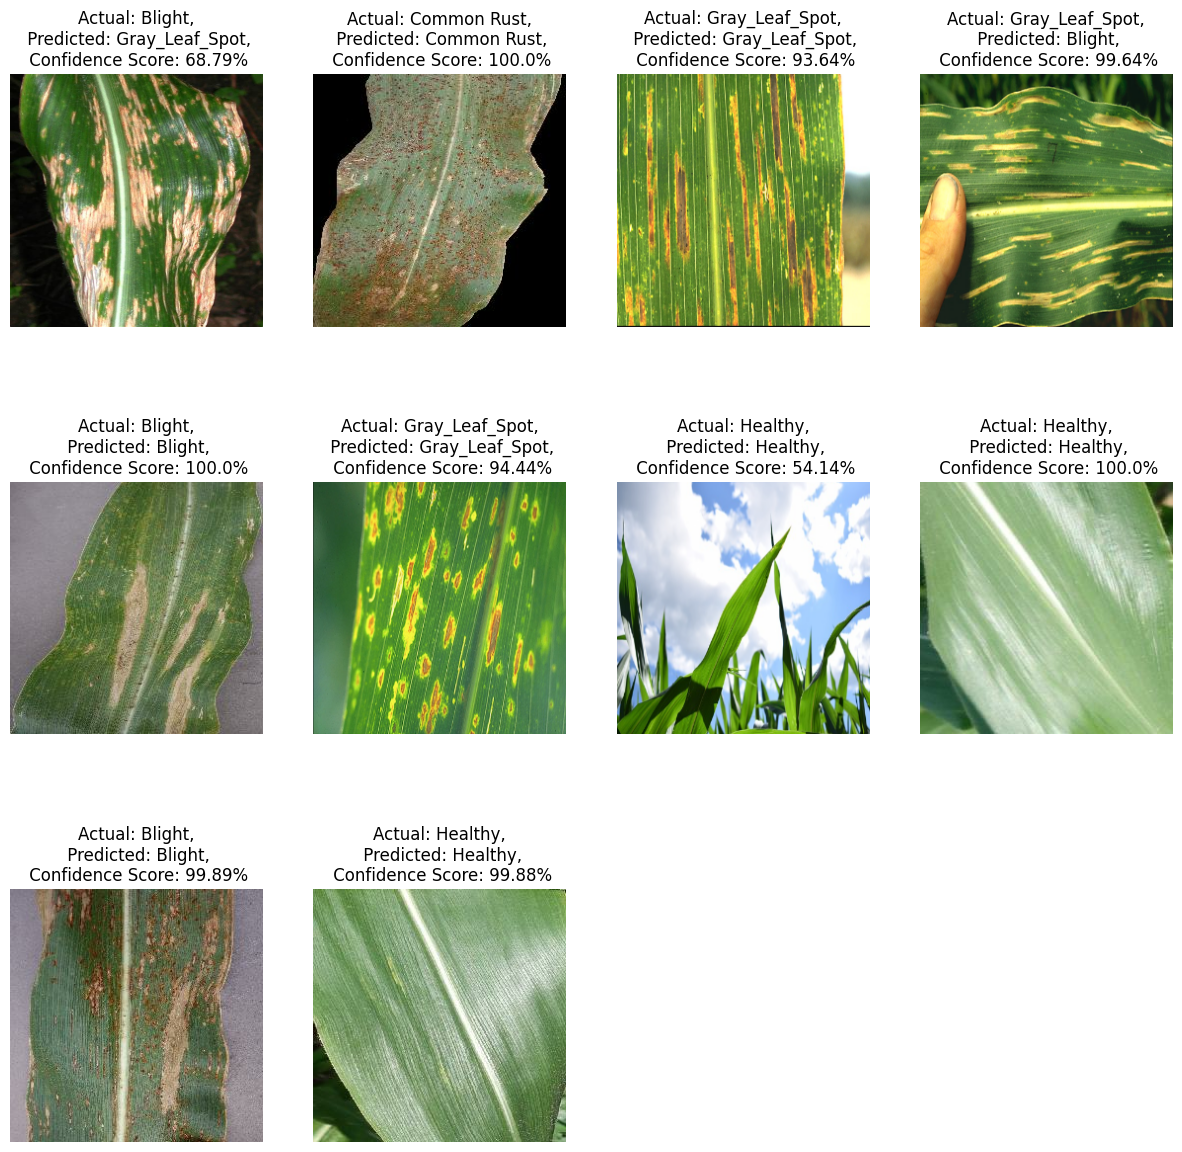

In [26]:
#Se grafica algunas imagenes del dataset de prueba con su prediccion
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(len(test_ds)):
    for i in range(10):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [27]:
ACTUAL=[]
PREDICTED=[]
#Se toma el dataset y se generan vectores para crear la matriz de confusion
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(len(test_ds)):
    for i in range(BATCH_SIZE):
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        ACTUAL.append(actual_class)
        PREDICTED.append(predicted_class)

1/1 [==============================] - 0s 18ms/step


<Figure size 1500x1500 with 0 Axes>

# Matriz de confusion

In [28]:
print(PREDICTED)
print(ACTUAL)

['Gray_Leaf_Spot', 'Common Rust', 'Healthy', 'Common Rust', 'Blight', 'Blight', 'Healthy', 'Blight', 'Common Rust', 'Blight', 'Common Rust', 'Gray_Leaf_Spot', 'Healthy', 'Gray_Leaf_Spot', 'Common Rust', 'Blight', 'Blight', 'Gray_Leaf_Spot', 'Healthy', 'Gray_Leaf_Spot', 'Healthy', 'Blight', 'Healthy', 'Healthy', 'Common Rust', 'Gray_Leaf_Spot', 'Common Rust', 'Gray_Leaf_Spot', 'Blight', 'Blight', 'Gray_Leaf_Spot', 'Healthy', 'Healthy', 'Blight', 'Healthy', 'Healthy', 'Healthy', 'Gray_Leaf_Spot', 'Blight', 'Common Rust', 'Common Rust', 'Healthy', 'Blight', 'Blight', 'Blight', 'Gray_Leaf_Spot', 'Healthy', 'Blight', 'Gray_Leaf_Spot', 'Common Rust', 'Blight', 'Blight', 'Blight', 'Common Rust', 'Healthy', 'Blight', 'Common Rust', 'Blight', 'Common Rust', 'Common Rust', 'Blight', 'Healthy', 'Gray_Leaf_Spot', 'Blight', 'Common Rust', 'Blight', 'Common Rust', 'Common Rust', 'Healthy', 'Common Rust', 'Blight', 'Common Rust', 'Healthy', 'Blight', 'Blight']
['Gray_Leaf_Spot', 'Common Rust', 'Healt

Text(0.5, 25.722222222222214, 'Actual')

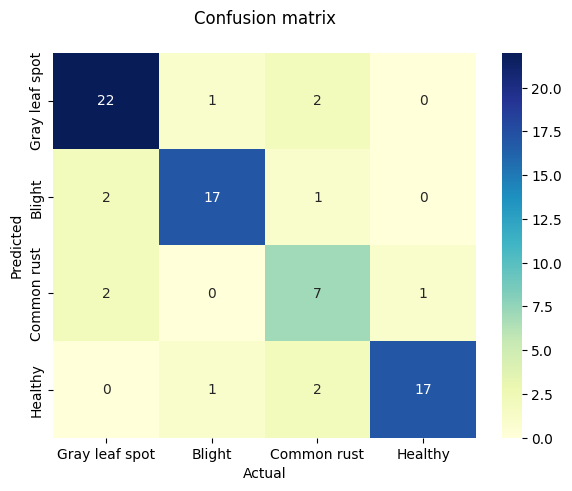

In [29]:
# @title Se muestra matriz de confusion para el dataset destinado a test
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))
cm = confusion_matrix(ACTUAL, PREDICTED)
df_cm = pd.DataFrame(cm, index=['Gray leaf spot', 'Blight', 'Common rust', 'Healthy'], columns=['Gray leaf spot', 'Blight', 'Common rust', 'Healthy'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")